# Imports

In [1]:
import requests, zipfile, io
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('adornmyplot.mplstyle')
import matplotlib as mpl

import pyvista as pv

import mmt_dipole_cuboid_inversion as dci
import mmt_dipole_cuboid_inversion.tools as dcit

import mmt_multipole_inversion as minv
import json

# Data

We start downloading the data of de Groot et al. (2018)\* from the public repository PANGAEA. The updated version of the data contains three areas that are pre-processed and where tomography and magnetometry coordinates are co-registered. We unzip the data and extract the contents.

*de Groot, L.V., Fabian, K., Béguin, A., Reith, P., Barnhoorn, A., Hilgenkamp, H., 2018. List of grains and results of the Scanning SQUID Magnetometer (SSM) scan. URL: https://doi.org/10.1594/PANGAEA.886724*

*de Groot, L.V., Fabian, K., Béguin, A., Reith, P., Barnhoorn, A., Hilgenkamp, H., 2018. Determining Individual Particle Magnetizations in Assemblages of Micrograins. Geophysical Research Letters 45, 2995–3000. URL: https://agupubs.onlinelibrary.wiley.com/doi/478*

In [2]:
# DATA ------------------------------------------------------------------------

# Download the data to this directory:
data_dir = Path('deGroot2018_data')
data_dir.mkdir(exist_ok=True)

if not any(data_dir.iterdir()):
    data_url = 'https://store.pangaea.de/Publications/deGroot-etal_2018/Micro-grain-data.zip'
    r = requests.get(data_url)
    # Pass the request output `r` (in byte-like format) to get a binary stream
    # from a data piece in memory (buffer) using BytesIO -> like a file in mem
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(data_dir)

# Now open the ZIP file with formatted data:
z = zipfile.ZipFile(data_dir / 'V2_2021-04.zip')
z.extractall(data_dir)

The following are the magnetization values reported by (de Groot et al., 2018), for the grains in Area 1 with unknown magnetizations:

In [3]:
dG_Area1UMS = np.array([3544.3, 3923.7, 15346.8, 3770.7, 28147.8, 2845.9, 92191.2, 7154.4])
dG_Area1UMS_anglesOld = [(75.7, -24.1), (198.6, -53.8), (255.2, -30.5), (116.3, 50.7), 
                         (26.7, 67.1), (138.3, -21.3), (101.9, 50.4), (249.2, 51.8)]
dG_Area1UMS_m = np.array([(3134.8, 799.1, -1448.0), (-739.7, -2196.0, -3166.3),
                          (-12790.5, -3376.5, -7779.9), (2141.7, -1059.0, 2917.1),
                          (4905.7, 9774.3, 25936.3), (1762.9, -1980.3, -1034.5),
                          (57489.5, -12129.5, 71042.6), (-4133.9, -1566.9, 5625.1)])

# Compute the angles from dG's magnetizations
m = np.copy(dG_Area1UMS_m)
phi = np.arctan2(m[:, 1], m[:, 0])  # arctan(y / x)
theta = np.arccos(m[:, 2] / np.linalg.norm(m, axis=1))  # arccos(z / r) ; r = sqrt(x^2 + y^2 + z^2)

dG_Area1UMS_anglesNew = np.column_stack((np.rad2deg(phi), np.rad2deg(theta)))
dG_Area1UMS_anglesNew[:, 0][dG_Area1UMS_anglesNew[:, 0] < 0] += 360
ftr = np.logical_and(dG_Area1UMS_anglesNew[:, 1] >= 0, dG_Area1UMS_anglesNew[:, 1] <= 180)
dG_Area1UMS_anglesNew[:, 1][ftr] -= 90
dG_Area1UMS_anglesNew[:, 1][ftr] *= -1

In [4]:
print('Corrected angles from de Groot (2018) (z-axis towards depth):')
print(dG_Area1UMS_anglesNew)

Corrected angles from de Groot (2018) (z-axis towards depth):
[[ 14.30084952 -24.1131827 ]
 [251.38443132 -53.80173894]
 [194.78787357 -30.46017388]
 [333.68912318  50.68120101]
 [ 63.34802457  67.13677847]
 [311.67607251 -21.31501278]
 [348.08610471  50.40785447]
 [200.75854906  51.83538878]]


# Visualize grains

In this section we make a visualization of the tomographic data. Tomography voxels are already aggregated into the largest possible cuboids using the `cuboid_aggregation` algorithm included in the `mmt_dipole_cuboid_inversion` library. The visualization is done using the PyVista library:

In [5]:
data_dir = Path('deGroot2018_data/PDI-16803')
# Location and name of QDM and cuboid file
ScanFile = data_dir / 'Area1-90-fig2MMT.txt'
CuboidFile = data_dir / 'FWInput-FineCuboids-A1.txt'
cuboid_data = np.loadtxt(CuboidFile, skiprows=0)
cuboid_data[:, 2] *= -1
idxs = cuboid_data[:, 6].astype(np.int16)

In [6]:
print('Cuboid data example: x y z dx dy dz index')
print(cuboid_data[:2, :])

Cuboid data example: x y z dx dy dz index
[[ 78.4  156.4  -10.12   3.52   5.28   3.08   1.  ]
 [ 77.96 153.76 -15.84   3.96   2.64   2.64   1.  ]]


In [7]:
# Make a block of data from every cuboid, for every particle; to plot the cuboids
block = pv.MultiBlock()
# g_idx = 1
for g_idx in range(1, 9):  # for every particle
    for cuboid in cuboid_data[idxs == g_idx]:  # for each of its cuboids
        # remember dx dy dz are half-lengths so we multiply by 2 to get cuboid extents:
        c = pv.Cube(center=cuboid[:3], x_length=2*cuboid[3], y_length=2*cuboid[4], z_length=2*cuboid[5])
        c.cell_data['Gindex'] = [g_idx for i in range(6)]  # 
        block.append(c)

block = block.combine()

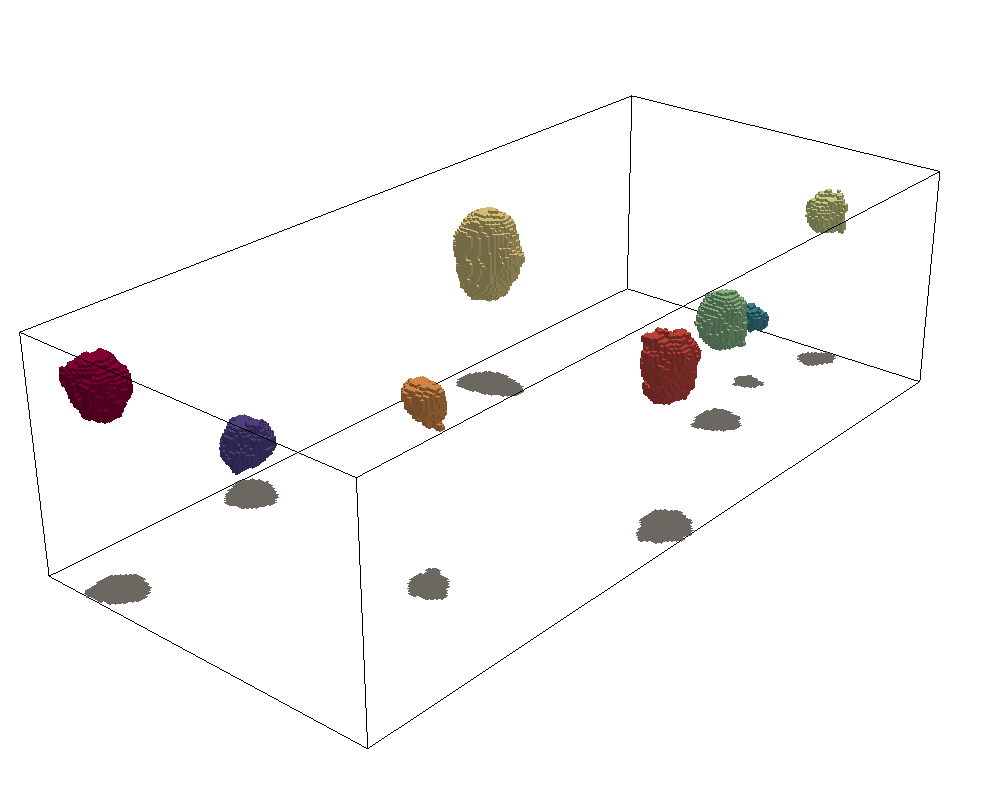

In [8]:
pV = pv.Plotter(off_screen=False, notebook=True, window_size=[1000, 800])
pV.set_background('white')

pV.add_mesh(block, scalars='Gindex', smooth_shading=False, show_scalar_bar=False,
            cmap='spectral')
# print (f"Loading mesh: {perf_counter() - t2}")

# Make the sample outline
box_lim = 0.17
box = pv.Box([cuboid_data[:, 0].min(), cuboid_data[:, 0].max(),
              cuboid_data[:, 1].min(), cuboid_data[:, 1].max(),
              cuboid_data[:, 2].min() - 10, 0.0])
pV.add_mesh(box.outline(), color='black', opacity=1, line_width=1)

# Make the grain shadows
pV.add_mesh(
    block.extract_geometry().project_points_to_plane(origin=(0, 0, cuboid_data[:, 2].min() - 10), 
                                                     normal=(0, 0, 1)),
                                                     opacity=1, style='surface', color='grey')
pV.view_isometric()
pV.camera.SetWindowCenter(-0.05, -0.1)
pV.camera.zoom(1.3)
pV.camera.azimuth = -185
pV.camera.elevation = -10

pV.show(jupyter_backend='static')

# Dipole Cuboid Inversion

In this section we apply the homogeneously magnetized particle model to do the inversions. This means cuboids are asumed uniformly magnetized and we obtain dipole order solutions from the inversions.

In [9]:
data_dir = Path('deGroot2018_data/PDI-16803')

# location and name of QDM and cuboid file
ScanFile = data_dir / 'Area1-90-fig2MMT.txt'
CuboidFile = data_dir / 'FWInput-FineCuboids-A1.txt'

cub_data = np.loadtxt(CuboidFile, skiprows=0)
cub_data[:, 2] *= -1

SQUID_sensor_domain = np.array([[0, 0], [350, 200]]) * 1e-6
SQUID_spacing = 1e-6
SQUID_deltax = 0.5e-6
SQUID_deltay = 0.5e-6
SQUID_area = 1e-12
scan_height = 2e-6

mag_inv = dci.DipoleCuboidInversion(None, SQUID_sensor_domain, SQUID_spacing,
        SQUID_deltax, SQUID_deltay, SQUID_area, scan_height, verbose=True)

mag_inv.read_files(ScanFile, cub_data, cuboid_scaling_factor=1e-6)
mag_inv.set_scan_domain(gen_sd_mesh_from='sensor_center_domain')

# We then compute the forward (Green's) matrix that we use to invert the scan field:
mag_inv.prepare_matrix(method='cython')

# And we do the inversion::::
# Notice that rtol is defined in Scipy with a default value of : max(M, N) * eps, 
# where eps is the machine precision value of the datatype of the Forward G matrix (here float64),
# and M,N are the dimensions of the matrix.
# eps is around 2.22e-16; however the smallest number that can be represented in Numpy is 
# substantially smaller, in the order of e-308; See: numpy.finfo
mag_inv.calculate_inverse(method='scipy_pinv', rtol=1e-20)

Start inversion with 70551 knowns and 24 unknowns
Inversion has been carried out


In [10]:
mag_dpinv = np.linalg.norm(mag_inv.Mag.reshape(-1, 3), axis=1)

In [11]:
print('Dipole cuboid inversion code - Magnetic moments:')
print(mag_dpinv)

Dipole cuboid inversion code - Magnetic moments:
[ 3467.09006523  3876.44978583 15131.96495676  3740.29552205
 27753.22027397  3059.00393443 92531.80980677  7430.47851852]


In [12]:
print('Dipole cuboid inversion code - Magnetizations:')
mag_inv.Mag.reshape(-1, 3)

Dipole cuboid inversion code - Magnetizations:


array([[  3073.47734671,    794.21817703,   1394.15494368],
       [  -721.16937776,  -2167.19695266,   3132.09754621],
       [-12596.9441177 ,  -3373.80667116,   7675.33653294],
       [  2116.48066373,  -1054.1587659 ,  -2898.11481632],
       [  4722.76616018,   9681.78237472, -25577.32991187],
       [  1958.37827699,  -2082.26593193,   1089.23284186],
       [ 54738.76498624,  -9395.10859099, -74010.37338415],
       [ -4592.66677199,  -1717.13844967,  -5583.08682364]])

In [13]:
# Compute spherical angles:
# array with the magnetizations. It's the same if we use normalized m
m = np.copy(mag_inv.Mag.reshape(-1, 3))
# mnorm = m / np.linalg.norm(m, axis=1)[:, np.newaxis]
phi = np.arctan2(m[:, 1], m[:, 0])  # arctan(y / x) for every row (particle)
theta = np.arccos(m[:, 2] / np.linalg.norm(m, axis=1))  # arccos(z / r) ; r = sqrt(x^2 + y^2 + z^2)

# Convert to degrees and correct angles: polar angles measured from equator and
# azimuthal angles in [0,360] degrees range
angles_dpinv = np.column_stack((np.rad2deg(phi), np.rad2deg(theta)))
angles_dpinv[:, 0][angles_dpinv[:, 0] < 0] += 360
ftr = np.logical_and(angles_dpinv[:, 1] >= 0, angles_dpinv[:, 1] <= 180)
angles_dpinv[:, 1][ftr] -= 90
angles_dpinv[:, 1][ftr] *= -1

In [14]:
print('Dipole cuboid inversion code - Angles:')
angles_dpinv

Dipole cuboid inversion code - Angles:


array([[ 14.48886701,  23.7102118 ],
       [251.59431336,  53.89913038],
       [194.99348855,  30.47927703],
       [333.52341147, -50.79014663],
       [ 63.99691474, -67.16092178],
       [313.24384024,  20.85930326],
       [350.26091101, -53.1145483 ],
       [200.50011718, -48.70975427]])

In [15]:
# Compute the volumes of the grains by summing its cuboid components
cuboidVols = np.zeros(8)
cuboidIdxs = cuboid_data[:, 6].astype(np.int16)
vols = 8 * cub_data[:, 3] * cub_data[:, 4] * cub_data[:, 5]
for i, particle_idx in enumerate(np.unique(cuboidIdxs)):
    p = cuboidIdxs == particle_idx
    cuboidVols[i] = vols[p].sum()

cuboidDepths = cub_data[:, 2] * (-1)

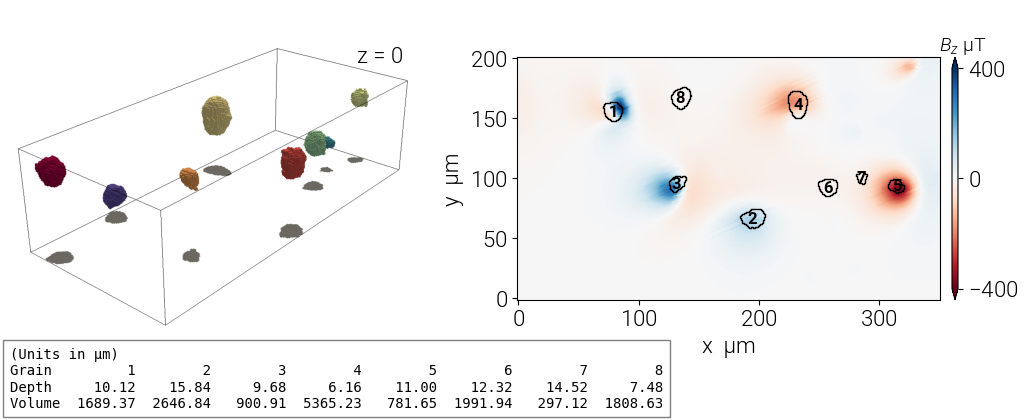

In [16]:
dcit.plot.set_grain_geometries(mag_inv, spatial_scaling=1e6)

f, axs = plt.subplots(ncols=2, figsize=(12, 8 * 200 / 350))

axs[0].imshow(pV.image)
axs[0].set_axis_off()
axs[0].text(0.93, 0.89, 'z = 0', va='top', ha='right',
            color='k', fontsize=16, transform=axs[0].transAxes)


# vlim = np.max(np.abs(mag_inv.scan_matrix / mag_inv.scan_area)) * 1e6
vlim = 400
dcit.plot.plot_grain_boundaries(mag_inv, axs[1], 
                                labels_args=dict(ha='center', va='center', fontsize=12, fontweight=600))
im = dcit.plot.plot_scan_field(mag_inv, axs[1], scale_field=1e6 / mag_inv.scan_area,
                               imshow_args=dict(cmap='RdBu', vmin=-vlim, vmax=vlim))
axs[1].set_xlabel('x  µm')
axs[1].set_ylabel('y  µm')

# COLORBAR
axL = axs[1].get_position()
axcb = f.add_axes([axL.x1 + 0.01, axL.y0, 0.005, axL.height])
cb = f.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=-vlim, vmax=vlim), cmap='RdBu'), 
                cax=axcb, orientation='vertical', # shrink=0.7, aspect=10, # pad=-0.8
                extend='both')
cb.ax.xaxis.set_ticks_position('top')
cb.set_ticks((-vlim, 0, vlim))
cb.set_label(r'$B_{z}$' + ' µT', fontsize=14, y=1.15, rotation=0, labelpad=-40)

depthLab = '(Units in µm)\n'
depthLab += 'Grain '
for i in range(8):
    depthLab += f'{i + 1:>9}'
depthLab += '\nDepth '
for i in range(8):
    depthLab += f'{cuboidDepths[i]:>9.2f}'

depthLab += '\nVolume'
for i in range(8):
    depthLab += f'{cuboidVols[i]:>9.2f}'

axs[0].text(0., 0.0, depthLab, va='top', ha='left',
            color='k', fontsize=10, fontfamily='monospace',
            bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 5},
            transform=axs[0].transAxes)


plt.savefig('figures/area1_degroot18_overview.pdf', bbox_inches='tight', dpi=200)
plt.show()

In [17]:
print(depthLab)

(Units in µm)
Grain         1        2        3        4        5        6        7        8
Depth     10.12    15.84     9.68     6.16    11.00    12.32    14.52     7.48
Volume  1689.37  2646.84   900.91  5365.23   781.65  1991.94   297.12  1808.63


# Multipole Inversion

In this section we apply the multipole expansion model for the inversions, thus we use the `mmt_multipole_inversion library`. Start by computing the particle centers from the tomography/cuboids data:

In [18]:
# -----------------------------------------------------------------------------
# DEFINE PARTICLES

data_dir = Path('deGroot2018_data/PDI-16803')

# Location and name of QDM and cuboid file
ScanFile = data_dir / 'Area1-90-fig2MMT.txt'
CuboidFile = data_dir / 'FWInput-FineCuboids-A1.txt'
# Load center and half lengths of cuboids making the grains (tomog data)
cuboid_data = np.loadtxt(CuboidFile, skiprows=0)
# x, y = np.copy(cuboid_data[:, 0]), np.copy(cuboid_data[:, 1])
# cuboid_data[:, 0] = y
# cuboid_data[:, 1] = x
cuboid_data[:, 2] *= -1

cuboid_data_idxs = cuboid_data[:, 6].astype(np.int16)
cx, cy, cz, cdx, cdy, cdz = (cuboid_data[:, i] for i in range(6))
vols = 8 * cdx * cdy * cdz

# Compute centers of mass (geometric centre) per p. into the particles array
particles = np.zeros((len(np.unique(cuboid_data_idxs)), 4))
centre = np.zeros(3)
for i, particle_idx in enumerate(np.unique(cuboid_data_idxs)):

    p = cuboid_data_idxs == particle_idx
    particle_vol = vols[p].sum()
    centre[0] = np.sum(cx[p] * vols[p]) / particle_vol
    centre[1] = np.sum(cy[p] * vols[p]) / particle_vol
    centre[2] = np.sum(cz[p] * vols[p]) / particle_vol

    particles[i][:3] = centre
    particles[i][3] = particle_vol

Now we define the sample:

In [19]:
# -----------------------------------------------------------------------------
# DEFINE SAMPLE

# Directory to save the files
BASE_DIR = Path('SyntheticSampleFiles')
BASE_DIR.mkdir(exist_ok=True)

# Scale the positions and columes by micrometres
np.savez(BASE_DIR / 'Area1_UMS_NPZ_ARRAYS',
         # Bz_array=,
         particle_positions=particles[:, :3] * 1e-6,
         # magnetization=self.magnetization,
         volumes=particles[:, 3] * 1e-18)

# Set dictionary with scanning surface parameters
metadict = {}
metadict["Scan height Hz"] = 2e-6
metadict["Scan area x-dimension Sx"] = 351 * 1e-6
metadict["Scan area y-dimension Sy"] = 201 * 1e-6
metadict["Scan x-step Sdx"] = 1e-6
metadict["Scan y-step Sdy"] = 1e-6
metadict["Time stamp"] = '0000'
metadict["Number of particles"] = 8
# Important!:
metadict["Sensor dimensions"] = (0.5e-6, 0.5e-6)

# Save dictionary into json file
with open(BASE_DIR / "AREA1_UMS_METADICT.json", 'w') as f:
    json.dump(metadict, f)

And, finally, we make the inversions using a 2D model for the magnetometer sensors. This is useful to compare the solutions against the HMP model:

In [20]:
# -----------------------------------------------------------------------------
# INVERSION

inv_area1_ums = minv.MultipoleInversion(
        BASE_DIR / "AREA1_UMS_METADICT.json",
        BASE_DIR / 'Area1_UMS_NPZ_ARRAYS.npz',
        expansion_limit='dipole',
        sus_functions_module='spherical_harmonics_basis_area')
# inv_area1_ums.sensor_dims = ()
# Load the scanning array manually:
inv_area1_ums.Bz_array = np.loadtxt(data_dir / 'Area1-90-fig2MMT.txt')

mag_minv_raw = {}
mag_minv = {}
angles_minv = {}
angles_minv_raw = {}
berr_minv = {}

for exp_limit in ['dipole', 'quadrupole']:
# for exp_limit in ['dipole']:
    inv_area1_ums.expansion_limit = exp_limit
    inv_area1_ums.compute_inversion(method='sp_pinv', rtol=1e-20)
    # inv_area1_ums.compute_inversion(rcond=1e-30, method='np_pinv')
    
    # print(inv_area1_ums.inv_multipole_moments[:, :3] / inv_area1_ums.volumes[:, None])
    
    # Compute magnetizations:
    mag = inv_area1_ums.inv_multipole_moments[:, :3] / inv_area1_ums.volumes[:, None]
    mag_area1_ums = np.sqrt(np.sum(mag ** 2, axis=1))
    
    mag_minv_raw[exp_limit] = inv_area1_ums.inv_multipole_moments[:, :3]
    
    # Compute spherical angles:
    m = mag / np.linalg.norm(m, axis=1)[:, None]  # normalized mag

    # phi = arctan(y / x)
    phi_area1_ums = np.arctan2(m[:, 1], m[:, 0])
    # theta = arccos(z / r) ; r = sqrt(x^2 + y^2 + z^2)
    theta_area1_ums = np.arccos(m[:, 2] / np.linalg.norm(m, axis=1))
 
    mag_minv[exp_limit] = mag_area1_ums
    angles_minv[exp_limit] = np.column_stack((np.rad2deg(phi_area1_ums),
                                              np.rad2deg(theta_area1_ums)))
   
    angles_minv[exp_limit][:, 0][angles_minv[exp_limit][:, 0] < 0] += 360
    ftr = np.logical_and(angles_minv[exp_limit][:, 1] >= 0, angles_minv[exp_limit][:, 1] <= 180)
    angles_minv[exp_limit][:, 1][ftr] -= 90
    angles_minv[exp_limit][:, 1][ftr] *= -1
    
    angles_minv_raw[exp_limit] = np.column_stack((np.rad2deg(phi_area1_ums),
                                                  np.rad2deg(theta_area1_ums)))
    
    berr_minv[exp_limit] = np.linalg.norm(inv_area1_ums.inv_Bz_array - inv_area1_ums.Bz_array)
    berr_minv[exp_limit] /= np.linalg.norm(inv_area1_ums.Bz_array)

*Bz_array* array required for calculations.  Set manually.
Parameter Sensor origin x not found in json file
Setting Sensor origin x value to 0.0
Parameter Sensor origin y not found in json file
Setting Sensor origin y value to 0.0
Scanning array size = 351 x 201
Generating forward matrix
Generation of Q matrix took: 6.9469 s
Using scipy.linalg.pinv for inversion
Generating forward matrix
Generation of Q matrix took: 1.4067 s
Using scipy.linalg.pinv for inversion


In [21]:
print('Multipole inversion code - Magnetizations:')
print(mag_minv)

Multipole inversion code - Magnetizations:
{'dipole': array([ 3384.14928415,  4384.65722375, 15265.62141898,  4190.41512272,
       28120.79203448,  2119.66057691, 88682.36504411,  6796.90000064]), 'quadrupole': array([ 4612.27561906,  6318.84058223, 19826.9883864 ,  4273.23720551,
       39414.44691799, 15929.64665508, 75612.760774  , 14666.92064884])}


In [22]:
print('Multipole inversion code - Magnetizations:')
print(angles_minv['dipole'])

Multipole inversion code - Magnetizations:
[[ 16.43078102  21.73713327]
 [248.23000614  49.05732027]
 [194.1794846   28.62747556]
 [337.27067732 -51.25602852]
 [ 64.3412182  -67.41172835]
 [305.30191709  22.80922409]
 [343.95454414 -50.71020077]
 [210.84657555 -53.1036977 ]]


In [23]:
print('Multipole inversion code - Angles:')
angles_minv

Multipole inversion code - Angles:


{'dipole': array([[ 16.43078102,  21.73713327],
        [248.23000614,  49.05732027],
        [194.1794846 ,  28.62747556],
        [337.27067732, -51.25602852],
        [ 64.3412182 , -67.41172835],
        [305.30191709,  22.80922409],
        [343.95454414, -50.71020077],
        [210.84657555, -53.1036977 ]]),
 'quadrupole': array([[352.3498672 ,  51.27369766],
        [237.76881549,  40.34111567],
        [172.69626689,  25.98699694],
        [ 11.22730216, -44.09069991],
        [  2.05338518, -50.60158061],
        [259.85815902, -24.02869794],
        [ 96.50607284,  62.14328874],
        [181.7998556 , -31.03943834]])}

## Multipole Inversion: Point Source

Here we perform multipole inversions but modelling the sensors as point sources (for comparison)

In [24]:
# -----------------------------------------------------------------------------
# INVERSION

inv_area1_ums = minv.MultipoleInversion(
        BASE_DIR / "AREA1_UMS_METADICT.json",
        BASE_DIR / 'Area1_UMS_NPZ_ARRAYS.npz',
        expansion_limit='dipole',
        sus_functions_module='spherical_harmonics_basis')
inv_area1_ums.sensor_dims = ()
# Load the scanning array manually:
inv_area1_ums.Bz_array = np.loadtxt(data_dir / 'Area1-90-fig2MMT.txt')

mag_minv_ps = {}
angles_minv_ps = {}
angles_minv_ps_raw = {}

for exp_limit in ['dipole', 'quadrupole', 'octupole']:
# for exp_limit in ['dipole']:
    inv_area1_ums.expansion_limit = exp_limit
    inv_area1_ums.compute_inversion(method='sp_pinv', rtol=1e-20)
    # inv_area1_ums.compute_inversion(rcond=1e-30, method='np_pinv')
    
    # print(inv_area1_ums.inv_multipole_moments[:, :3] / inv_area1_ums.volumes[:, None])
    
    # Compute magnetizations:
    mag = inv_area1_ums.inv_multipole_moments[:, :3] / inv_area1_ums.volumes[:, None]
    mag_area1_ums = np.sqrt(np.sum(mag ** 2, axis=1))
    
    # Compute sph angles:
    m = mag / np.linalg.norm(m, axis=1)[:, None]

    # phi = arctan(y / x)
    phi_area1_ums = np.arctan2(m[:, 1], m[:, 0])
    # theta = arccos(z / r) ; r = sqrt(x^2 + y^2 + z^2)
    theta_area1_ums = np.arccos(m[:, 2] / np.linalg.norm(m, axis=1))

    mag_minv_ps[exp_limit] = mag_area1_ums
    angles_minv_ps[exp_limit] = np.column_stack((np.rad2deg(phi_area1_ums),
                                                 np.rad2deg(theta_area1_ums)))
   
    angles_minv_ps[exp_limit][:, 0][angles_minv_ps[exp_limit][:, 0] < 0] += 360
    ftr = np.logical_and(angles_minv_ps[exp_limit][:, 1] >= 0, angles_minv_ps[exp_limit][:, 1] <= 180)
    angles_minv_ps[exp_limit][:, 1][ftr] -= 90
    angles_minv_ps[exp_limit][:, 1][ftr] *= -1
    
    angles_minv_ps_raw[exp_limit] = np.column_stack((np.rad2deg(phi_area1_ums),
                                                     np.rad2deg(theta_area1_ums)))

*Bz_array* array required for calculations.  Set manually.
Parameter Sensor origin x not found in json file
Setting Sensor origin x value to 0.0
Parameter Sensor origin y not found in json file
Setting Sensor origin y value to 0.0
Scanning array size = 351 x 201
Generating forward matrix
Generation of Q matrix took: 3.1395 s
Using scipy.linalg.pinv for inversion
Generating forward matrix
Generation of Q matrix took: 3.4391 s
Using scipy.linalg.pinv for inversion
Generating forward matrix
Generation of Q matrix took: 6.7451 s
Using scipy.linalg.pinv for inversion


# Comparison

In this section we compute the relative errors $B_{\text{err}}$ and the comparison of the magnetization values between the HMP model, the MPE model, and the original data reported by de Groot et al. (2018)

In [25]:
# Not a good indicator as there are grains with very large errors
Berrs = np.zeros(3)

dci_bzinv = mag_inv.forward_field()
dci_bz = mag_inv.scan_matrix / mag_inv.scan_area
Berrs[0] = np.linalg.norm(dci_bzinv - dci_bz, ord='fro')
Berrs[0] /= np.linalg.norm(dci_bz, ord='fro')

Berrs[1] = berr_minv['dipole']
Berrs[2] = berr_minv['quadrupole']

In [26]:
# header = f"{'MultInv[dipole]':>27}"
# header += f"{'MultInv[quadrup]':>22}"
# # header += f"{'MultInv[octupole]':>22}"
# header += f"{'DipCubInv':>15}"
# header += f"{'de Groot (2018)':>22}"
# print('Inversion error Berr')
# print('-' * 87)
# print(header)
# print('-' * 87)
# print(f'{Berrs[0]:>22.2f}')

print('Magnetization in units of A / m')
print('-' * 87)
header = f"{'Grain':>5}"
header += f"{'MultInv[dipole]':>22}"
header += f"{'MultInv[quadrup]':>22}"
# header += f"{'MultInv[octupole]':>22}"
header += f"{'DipCubInv':>15}"
header += f"{'de Groot (2018)*':>22}"
print(header)
print('-' * 87)
for i in range(8):
    res = f"{i + 1:>3}"
    res += f"{mag_minv['dipole'][i]:>22.3f}"
    res += f"{mag_minv['quadrupole'][i]:>20.3f}"
    # res += f"{mag_minv['octupole'][i]:>22.3f}"
    res += f"{mag_dpinv[i]:>19.3f}"
    res += f"{dG_Area1UMS[i]:>20.3f}"
    
    print(res)

print('\nPairs of (φ,θ) magnetization angles in degrees. Polar angles positive above the equator')
print('-' * 87)
print(header)
print('-' * 87)
for i in range(8):
    res = f"{i + 1:>3}"
    res += f"{'(':>9}{angles_minv['dipole'][i][0]:>6.2f}, {angles_minv['dipole'][i][1]:>6.2f})"
    res += f"{'(':>6}{angles_minv['quadrupole'][i][0]:>6.2f}, {angles_minv['quadrupole'][i][1]:>6.2f})"
    # res += f"{mag_minv['octupole'][i]:>19.3f}"
    res += f"{'(':>4}{angles_dpinv[i][0]:>6.2f}, {angles_dpinv[i][1]:>6.2f})"
    res += f"{'(':>3}{dG_Area1UMS_anglesNew[i][0]:>6.2f}, {-dG_Area1UMS_anglesNew[i][1]:>6.2f})"
    
    print(res)

print('\n * Positive z-axis in de Groot (2018) point towards depth.')
print('   θ values here are inverted. φ values are re-computed.')
print('\n- Multipole Inversions using area sensors\n')

Magnetization in units of A / m
---------------------------------------------------------------------------------------
Grain       MultInv[dipole]      MultInv[quadrup]      DipCubInv      de Groot (2018)*
---------------------------------------------------------------------------------------
  1              3384.149            4612.276           3467.090            3544.300
  2              4384.657            6318.841           3876.450            3923.700
  3             15265.621           19826.988          15131.965           15346.800
  4              4190.415            4273.237           3740.296            3770.700
  5             28120.792           39414.447          27753.220           28147.800
  6              2119.661           15929.647           3059.004            2845.900
  7             88682.365           75612.761          92531.810           92191.200
  8              6796.900           14666.921           7430.479            7154.400

Pairs of (φ,θ) magnetiza

The following is the same comparison but using point-sensors for the Multipole inversions:

In [27]:
print('\n' + '-' * 100)
header = f"{'Grain':>5}"
header += f"{'MultInv[dipole]':>20}"
header += f"{'MultInv[quadrupole]':>20}"
header += f"{'MultInv[octupole]':>20}"
header += f"{'DipoleInv':>14}"
header += f"{'de Groot (2018)':>20}"
print(header)

for i in range(8):
    res = f"{i + 1:>3}"
    res += f"{mag_minv_ps['dipole'][i]:>19.3f}"
    res += f"{mag_minv_ps['quadrupole'][i]:>19.3f}"
    res += f"{mag_minv_ps['octupole'][i]:>19.3f}"
    res += f"{mag_dpinv[i]:>19.3f}"
    res += f"{dG_Area1UMS[i]:>19.3f}"
    
    print(res)
    
print('\n- Multipole Inversion using point sensors')


----------------------------------------------------------------------------------------------------
Grain     MultInv[dipole] MultInv[quadrupole]   MultInv[octupole]     DipoleInv     de Groot (2018)
  1           3379.871           4611.900           4488.817           3467.090           3544.300
  2           4382.546           6317.077           8050.031           3876.450           3923.700
  3          15254.746          19824.005          20020.999          15131.965          15346.800
  4           4189.074           4272.981           6485.511           3740.296           3770.700
  5          28101.039          39430.480          24534.983          27753.220          28147.800
  6           2130.350          15965.358         530939.068           3059.004           2845.900
  7          88693.396          75775.393        3637394.753          92531.810          92191.200
  8           6809.542          14723.426          34807.051           7430.479           7154.400

- Mul